In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [312]:
df = pd.read_csv('data/Mall_Customers.csv')
df

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


# Nettoyer et explorer les données

In [313]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [315]:
df.isna().count()

CustomerID                200
Genre                     200
Age                       200
Annual Income (k$)        200
Spending Score (1-100)    200
dtype: int64

In [316]:
df.duplicated().sum()

np.int64(0)

In [317]:
df = df.drop(columns='CustomerID', axis=1)

Genre
Female    112
Male       88
Name: count, dtype: int64


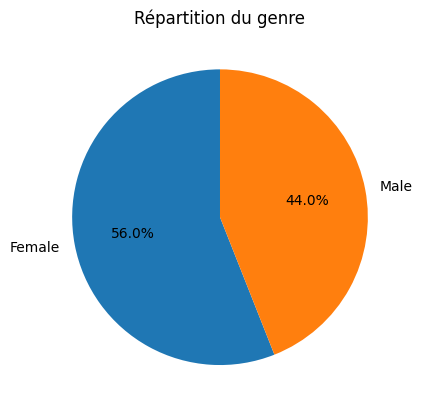

In [318]:
groups = df['Genre'].value_counts()
print(groups)


plt.pie(groups, labels=groups.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition du genre")
plt.show()


Shapiro-Wilk Test pour Age: stat=0.9516, p=0.0000
La variable Age ne suit pas une distribution normale (Shapiro-Wilk)



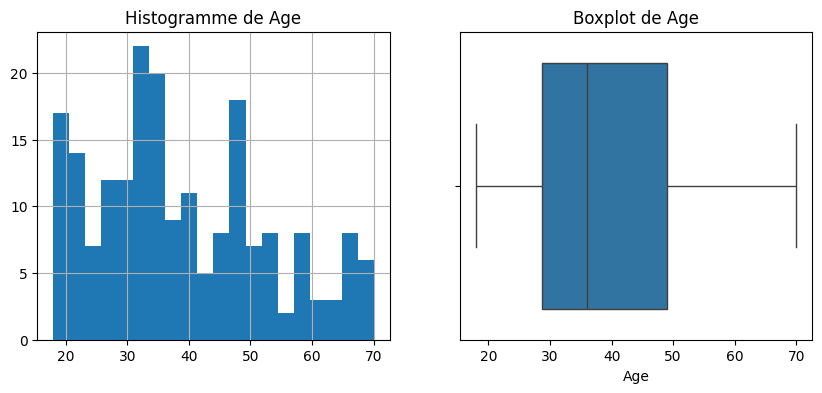

Shapiro-Wilk Test pour Annual Income (k$): stat=0.9784, p=0.0035
La variable Annual Income (k$) ne suit pas une distribution normale (Shapiro-Wilk)



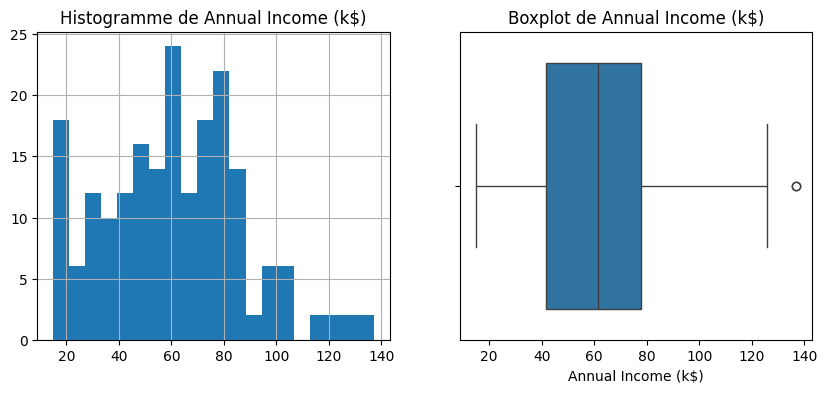

Shapiro-Wilk Test pour Spending Score (1-100): stat=0.9695, p=0.0002
La variable Spending Score (1-100) ne suit pas une distribution normale (Shapiro-Wilk)



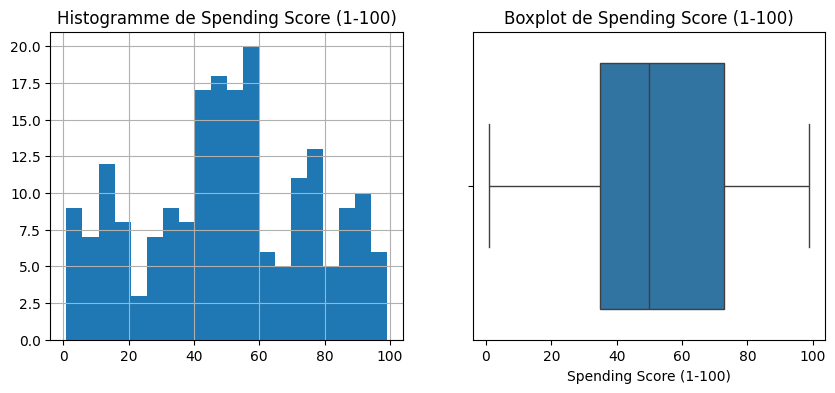

In [319]:
from scipy.stats import shapiro

# Sélection des colonnes numériques
nums = df.select_dtypes(include=['int', 'float']).columns

for num in nums:
    # Test de Shapiro-Wilk
    stat, p_value = shapiro(df[num])
    print(f"Shapiro-Wilk Test pour {num}: stat={stat:.4f}, p={p_value:.4f}")
    
    if p_value > 0.05:
        print(f"La variable {num} suit une distribution normale (Shapiro-Wilk)\n")
    else:
        print(f"La variable {num} ne suit pas une distribution normale (Shapiro-Wilk)\n")
    
    # Histogramme
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    df[num].hist(bins=20)
    plt.title(f"Histogramme de {num}")
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[num])
    plt.title(f"Boxplot de {num}")
    
    plt.show()

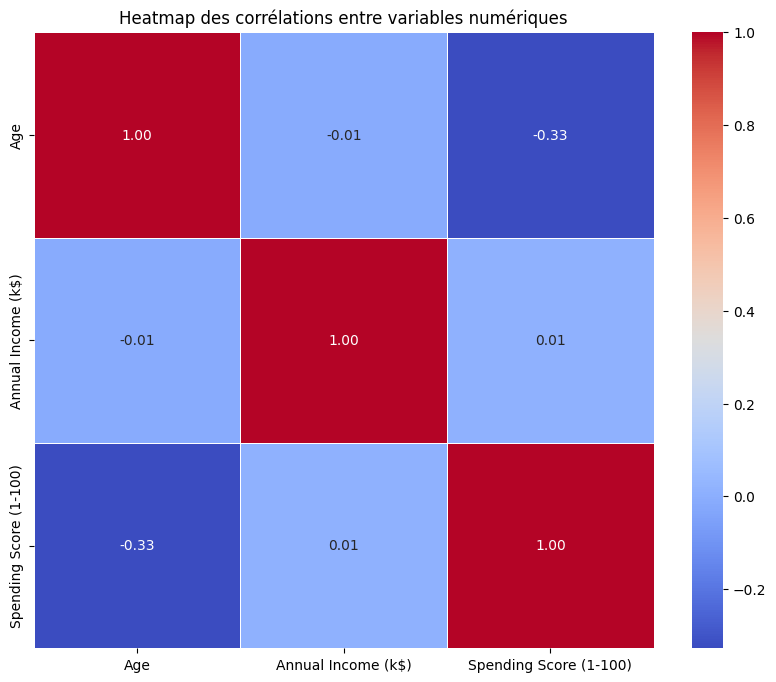

In [320]:
corr_matrix = df[nums].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap des corrélations entre variables numériques")
plt.show()

In [321]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, dbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist
from math import pi
import joblib

X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

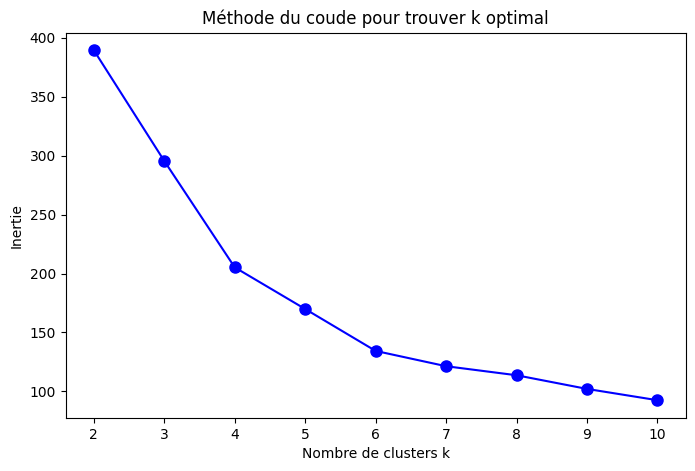

In [322]:
inertia = []
K = range(2, 11)  # tester k de 2 à 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graphique du coude
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Nombre de clusters k')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour trouver k optimal')
plt.show()


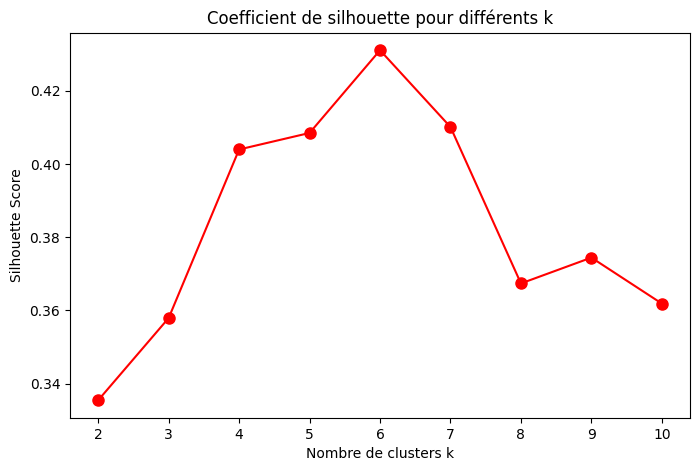

In [323]:
sil_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# Graphique
plt.figure(figsize=(8,5))
plt.plot(K, sil_scores, 'ro-', markersize=8)
plt.xlabel('Nombre de clusters k')
plt.ylabel('Silhouette Score')
plt.title('Coefficient de silhouette pour différents k')
plt.show()


In [324]:
k_optimal = 6
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df['Segment'] = kmeans.fit_predict(X_scaled)

sil_score = silhouette_score(X_scaled, df['Segment'])
print("Silhouette Score :", sil_score)


Silhouette Score : 0.43106526216603014


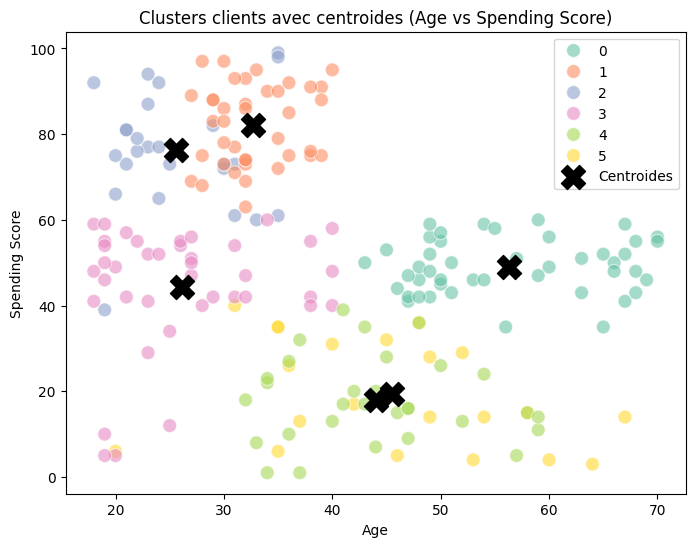

In [325]:
# Centroides dans l'espace normalisé
centroids_scaled = kmeans.cluster_centers_

# Centroides dans l'espace original
centroids = scaler.inverse_transform(centroids_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x='Age', y='Spending Score (1-100)',
                hue='Segment', palette='Set2', data=df, s=100, alpha=0.6)

# Ajouter les centroides
plt.scatter(centroids[:,0], centroids[:,2],  # Age vs Spending Score
            s=300, c='black', marker='X', label='Centroides')

plt.title('Clusters clients avec centroides (Age vs Spending Score)')
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.legend()
plt.show()


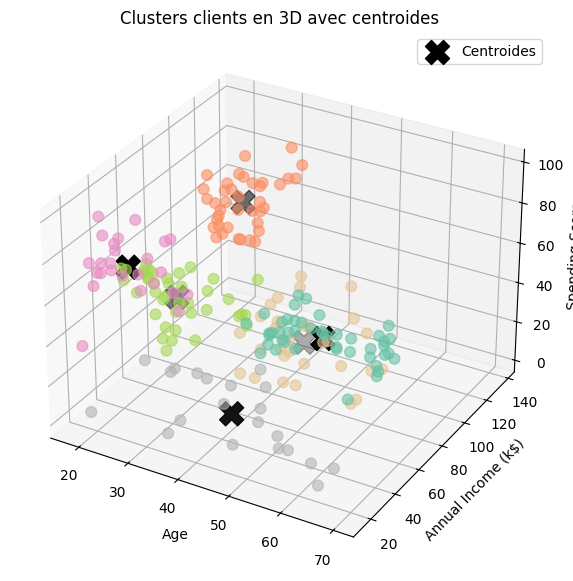

In [326]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Points clients
ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'],
           c=df['Segment'], cmap='Set2', s=60, alpha=0.6)

# Centroides
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2],
           c='black', s=300, marker='X', label='Centroides')

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.title('Clusters clients en 3D avec centroides')
plt.legend()
plt.show()


# mesure

In [327]:
df['cluster_label'] = kmeans.labels_  # Assignation des clusters à chaque client
cluster_stats = df.groupby('cluster_label')[nums].mean()  # Moyenne par cluster
cluster_stats


,Age,Annual Income (k$),Spending Score (1-100)
cluster_label,,,
0,56.333333,54.266667,49.066667
1,32.692308,86.538462,82.128205
2,25.560000,26.480000,76.240000
3,26.125000,59.425000,44.450000
4,44.000000,90.133333,17.933333
5,45.523810,26.285714,19.380952


In [328]:
# Supposons que df contient 'cluster_label' et les colonnes numériques
nums = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Calculer les moyennes par cluster
cluster_stats = df.groupby('cluster_label')[nums].mean().reset_index()

# Arrondir les valeurs pour la lisibilité
cluster_stats[nums] = cluster_stats[nums].round(0).astype(int)

# Ajouter Profil type et Action marketing
profil_dict = {
    0: "Seniors, revenu moyen, dépense moyenne",
    1: "Jeunes adultes à haut revenu, dépense élevée",
    2: "Jeunes, revenu faible, dépense élevée",
    3: "Jeunes adultes, revenu moyen, dépense moyenne",
    4: "Adultes à revenu élevé, faible dépense",
    5: "Adultes, faible revenu et faible dépense"
}

action_dict = {
    0: "Offres d’épargne, fidélisation",
    1: "Promotions sur produits premium, cross-sell",
    2: "Offres abordables, cartes fidélité, mobile",
    3: "Promotions ciblées, offres régulières",
    4: "Cross-sell assurance/épargne, fidélisation",
    5: "Produits d’épargne simples, sensibilisation à services"
}

cluster_stats['Profil_type'] = cluster_stats['cluster_label'].map(profil_dict)
cluster_stats['Action_marketing'] = cluster_stats['cluster_label'].map(action_dict)

# Afficher le tableau final
print(cluster_stats)

   cluster_label  Age  Annual Income (k$)  Spending Score (1-100)  \
0              0   56                  54                      49   
1              1   33                  87                      82   
2              2   26                  26                      76   
3              3   26                  59                      44   
4              4   44                  90                      18   
5              5   46                  26                      19   

                                     Profil_type  \
0         Seniors, revenu moyen, dépense moyenne   
1   Jeunes adultes à haut revenu, dépense élevée   
2          Jeunes, revenu faible, dépense élevée   
3  Jeunes adultes, revenu moyen, dépense moyenne   
4         Adultes à revenu élevé, faible dépense   
5       Adultes, faible revenu et faible dépense   

                                    Action_marketing  
0                     Offres d’épargne, fidélisation  
1        Promotions sur produits premium,

In [329]:
# Ajouter les colonnes au DataFrame
df['Profil_type'] = df['cluster_label'].map(profil_dict)
df['Action_marketing'] = df['cluster_label'].map(action_dict)

# Vérifier
df


,Genre,Age,Annual Income (k$),Spending Score (1-100),Segment,cluster_label,Profil_type,Action_marketing
0,Male,19,15,39,2,2,"Jeunes, revenu faible, dépense élevée","Offres abordables, cartes fidélité, mobile"
1,Male,21,15,81,2,2,"Jeunes, revenu faible, dépense élevée","Offres abordables, cartes fidélité, mobile"
2,Female,20,16,6,5,5,"Adultes, faible revenu et faible dépense","Produits d’épargne simples, sensibilisation à ..."
3,Female,23,16,77,2,2,"Jeunes, revenu faible, dépense élevée","Offres abordables, cartes fidélité, mobile"
4,Female,31,17,40,5,5,"Adultes, faible revenu et faible dépense","Produits d’épargne simples, sensibilisation à ..."
...,...,...,...,...,...,...,...,...
195,Female,35,120,79,1,1,"Jeunes adultes à haut revenu, dépense élevée","Promotions sur produits premium, cross-sell"
196,Female,45,126,28,4,4,"Adultes à revenu élevé, faible dépense","Cross-sell assurance/épargne, fidélisation"
197,Male,32,126,74,1,1,"Jeunes adultes à haut revenu, dépense élevée","Promotions sur produits premium, cross-sell"
198,Male,32,137,18,4,4,"Adultes à revenu élevé, faible dépense","Cross-sell assurance/épargne, fidélisation"


# sauvegarde du modele

In [330]:
scaler = StandardScaler()
scaler.fit(df[['Age','Annual Income (k$)','Spending Score (1-100)']])

joblib.dump(kmeans, 'model/kmeans_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')

['model/scaler.pkl']

In [331]:
import joblib
scaler = joblib.load('model/scaler.pkl')
print(type(scaler))
# doit afficher : <class 'sklearn.preprocessing._data.StandardScaler'>


<class 'sklearn.preprocessing._data.StandardScaler'>
